<a href="https://colab.research.google.com/github/idrisinanoglu/DSA210-Project/blob/main/DSA_210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Collection – Weather Data

In this section, daily weather data for Istanbul is collected using the Meteostat API.
The dataset includes key meteorological variables such as average temperature,
precipitation, wind speed, and atmospheric pressure.

## Data Collection – Google Trends

Google Trends data is collected for analyzing public mood
and behavioral patterns. Due to the fact that Google Trends allows a maximum of five keywords per
request keywords are grouped by category and queried separately.

The keywords are organized into four conceptual categories:
- **Negative Mood:** terms related to psychological distress and negative emotions
- **Positive Mood:** terms reflecting positive emotional states
- **Negative Behavioral Indicators:** terms associated with fatigue, isolation, and sleep issues
- **Positive Behavioral Indicators:** terms related to physical activity and outdoor engagement

Weekly search interest data is retrieved for Istanbul (TR-34) between January 2022 and December 2024.


In [1]:

!pip -q uninstall -y meteostat
!pip -q install meteostat==1.7.6 pytrends==4.9.2

import meteostat
print("meteostat version:", meteostat.__version__)


meteostat version: 1.7.6


In [2]:
# ==== IMPORT TEST ====
from datetime import datetime
from meteostat import Point, Daily
from pytrends.request import TrendReq

print("Imports OK")


Imports OK


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from meteostat import Point, Daily

plt.style.use("default")
sns.set()

istanbul = Point(41.0082, 28.9784)

start = datetime(2022, 1, 1)
end = datetime(2024, 12, 31)

weather_daily = Daily(istanbul, start, end).fetch()
weather_daily = weather_daily.drop(columns=["tsun","snow","wdir","wpgt"], errors="ignore")
weather_daily["prcp"] = weather_daily["prcp"].fillna(0)

weather_daily.to_csv("weather_istanbul_2022_2024.csv")
weather_daily.head()


,tavg,tmin,tmax,prcp,wspd,pres
time,,,,,,
2022-01-01,8.9,6.9,10.2,2.3,11.5,1019.6
2022-01-02,10.0,8.0,12.2,2.0,6.7,1024.0
2022-01-03,10.0,7.4,12.0,0.0,15.2,1018.7
2022-01-04,11.0,9.0,13.0,0.0,10.1,1015.8
2022-01-05,12.8,10.9,15.0,0.0,16.6,1012.9


Some meteorological variables (e.g., sunshine duration and wind direction)
were not available for the selected station and contained only missing values.
These variables were excluded from the analysis. Core variables such as
temperature and precipitation were fully observed and used in subsequent analyses.


In [4]:
import pandas as pd

w = pd.read_csv("weather_istanbul_2022_2024.csv")
print("Rows:", len(w))
print("Date min:", w.iloc[:,0].min())
print("Date max:", w.iloc[:,0].max())
print("Missing per col (%):")
print((w.isna().mean()*100).round(2).sort_values(ascending=False).head(10))
w.head()


Rows: 1096
Date min: 2022-01-01
Date max: 2024-12-31
Missing per col (%):
time    0.0
tavg    0.0
tmin    0.0
tmax    0.0
prcp    0.0
wspd    0.0
pres    0.0
dtype: float64


,time,tavg,tmin,tmax,prcp,wspd,pres
0,2022-01-01,8.9,6.9,10.2,2.3,11.5,1019.6
1,2022-01-02,10.0,8.0,12.2,2.0,6.7,1024.0
2,2022-01-03,10.0,7.4,12.0,0.0,15.2,1018.7
3,2022-01-04,11.0,9.0,13.0,0.0,10.1,1015.8
4,2022-01-05,12.8,10.9,15.0,0.0,16.6,1012.9


In [6]:
from pytrends.request import TrendReq
import pandas as pd

pytrends = TrendReq(hl="tr-TR", tz=180)

group1 = ["depresyon", "kaygı", "anksiyete", "stres", "bunalım"]
group2 = ["mutlu", "mutluluk", "huzurlu", "iyi hissetmek"]
group3 = ["yalnızlık", "uykusuzluk", "yorgunluk"]
group4 = ["spor salonu", "yürüyüş"]

def get_trends_for_group(kw_list):
    pytrends.build_payload(
        kw_list=kw_list,
        geo="TR-34",
        timeframe="2022-01-01 2024-12-31"
    )
    df = pytrends.interest_over_time()
    if "isPartial" in df.columns:
        df = df.drop(columns=["isPartial"])
    return df

t1 = get_trends_for_group(group1)
t2 = get_trends_for_group(group2)
t3 = get_trends_for_group(group3)
t4 = get_trends_for_group(group4)

trends_idx = pd.DataFrame({
    "NegativeMoodIndex": t1[group1].mean(axis=1),
    "PositiveMoodIndex": t2[group2].mean(axis=1),
    "NegativeBehaviorIndex": t3[group3].mean(axis=1),
    "PositiveBehaviorIndex": t4[group4].mean(axis=1),
})

trends_idx = (trends_idx - trends_idx.mean()) / trends_idx.std()

trends_idx.head()


,NegativeMoodIndex,PositiveMoodIndex,NegativeBehaviorIndex,PositiveBehaviorIndex
date,,,,
2021-12-26,-2.123453,6.911317,-0.235446,-2.839346
2022-01-02,0.215610,1.554057,0.142224,-1.581206
2022-01-09,-0.444126,1.171396,-0.329863,-1.311605
2022-01-16,-0.684030,0.150966,-0.801950,-1.401472
2022-01-23,-0.024294,0.150966,-0.424280,-1.221738


In [7]:
import pandas as pd

weather_daily = pd.read_csv("weather_istanbul_2022_2024.csv", index_col=0)
weather_daily.index = pd.to_datetime(weather_daily.index)

weather_daily["prcp"] = weather_daily["prcp"].fillna(0)

weather_weekly = weather_daily.resample("W-SUN").agg({
    "tavg": "mean",
    "tmin": "mean",
    "tmax": "mean",
    "wspd": "mean",
    "pres": "mean",
    "prcp": "sum"
})

weather_weekly["temp_range_week"] = (
    weather_daily["tmax"].resample("W-SUN").max()
    - weather_daily["tmin"].resample("W-SUN").min()
)

trends_idx.index = pd.to_datetime(trends_idx.index)

combined = weather_weekly.join(trends_idx, how="inner")

combined.to_csv("combined_weather_trends_istanbul_TR34_2022_2024.csv")
print(combined.shape)

combined.head()


(157, 11)


,tavg,tmin,tmax,wspd,pres,prcp,temp_range_week,NegativeMoodIndex,PositiveMoodIndex,NegativeBehaviorIndex,PositiveBehaviorIndex
2022-01-02,9.450000,7.450000,11.200000,9.100000,1021.800000,4.3,5.3,0.215610,1.554057,0.142224,-1.581206
2022-01-09,11.171429,9.185714,13.471429,13.857143,1014.342857,9.4,8.6,-0.444126,1.171396,-0.329863,-1.311605
2022-01-16,5.042857,2.257143,7.314286,22.957143,1019.328571,30.5,14.0,-0.684030,0.150966,-0.801950,-1.401472
2022-01-23,3.528571,-0.128571,6.185714,21.500000,1021.614286,39.7,12.2,-0.024294,0.150966,-0.424280,-1.221738
2022-01-30,2.242857,-1.357143,4.328571,15.371429,1022.885714,9.5,17.0,-0.744006,0.661181,-0.046611,0.126269


from matplotlib import pyplot as plt
_df_0['tavg'].plot(kind='hist', bins=20, title='tavg')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['tmin'].plot(kind='hist', bins=20, title='tmin')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['tmax'].plot(kind='hist', bins=20, title='tmax')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['wspd'].plot(kind='hist', bins=20, title='wspd')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='tavg', y='tmin', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='tmin', y='tmax', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='tmax', y='wspd', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='wspd', y='pres', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['tavg'].plot(kind='line', figsize=(8, 4), title='tavg')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['tmin'].plot(kind='line', figsize=(8, 4), title='tmin')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['tmax'].plot(kind='line', figsize=(8, 4), title='tmax')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['wspd'].plot(kind='line', figsize=(8, 4), title='wspd')
plt.gca().spines[['top', 'right']].set_visible(False)

## Exploratory Analysis and Hypothesis Testing

In the following section, the collected datasets are explored and visualized,
and the proposed hypotheses are evaluated using statistical analysis.


Shape: (157, 11)


,tavg,tmin,tmax,wspd,pres,prcp,temp_range_week,NegativeMoodIndex,PositiveMoodIndex,NegativeBehaviorIndex,PositiveBehaviorIndex
2022-01-02,9.450000,7.450000,11.200000,9.100000,1021.800000,4.3,5.3,0.215610,1.554057,0.142224,-1.581206
2022-01-09,11.171429,9.185714,13.471429,13.857143,1014.342857,9.4,8.6,-0.444126,1.171396,-0.329863,-1.311605
2022-01-16,5.042857,2.257143,7.314286,22.957143,1019.328571,30.5,14.0,-0.684030,0.150966,-0.801950,-1.401472


,count,mean,std,min,25%,50%,75%,max
tavg,157.0,16.523703,7.141250,1.971429,10.500000,15.614286,23.042857,29.542857
tmin,157.0,13.378389,6.781294,-1.357143,7.857143,12.057143,19.628571,25.514286
tmax,157.0,20.017834,7.822092,3.871429,13.585714,19.471429,27.700000,34.771429
wspd,157.0,16.496360,4.145772,8.585714,13.742857,16.342857,19.157143,27.542857
pres,157.0,1016.107825,5.018419,1008.014286,1012.614286,1014.957143,1018.842857,1032.914286
prcp,157.0,11.432484,15.557685,0.000000,0.600000,5.800000,16.100000,118.300000
temp_range_week,157.0,12.122930,2.841291,5.300000,10.100000,11.800000,14.000000,22.300000
NegativeMoodIndex,157.0,0.013525,0.988596,-2.543284,-0.684030,-0.024294,0.755393,2.374744
PositiveMoodIndex,157.0,-0.044021,0.835623,-2.272557,-0.614357,-0.104142,0.406073,4.232687
NegativeBehaviorIndex,157.0,0.001500,1.003022,-1.840540,-0.424280,-0.046611,0.142224,7.412358


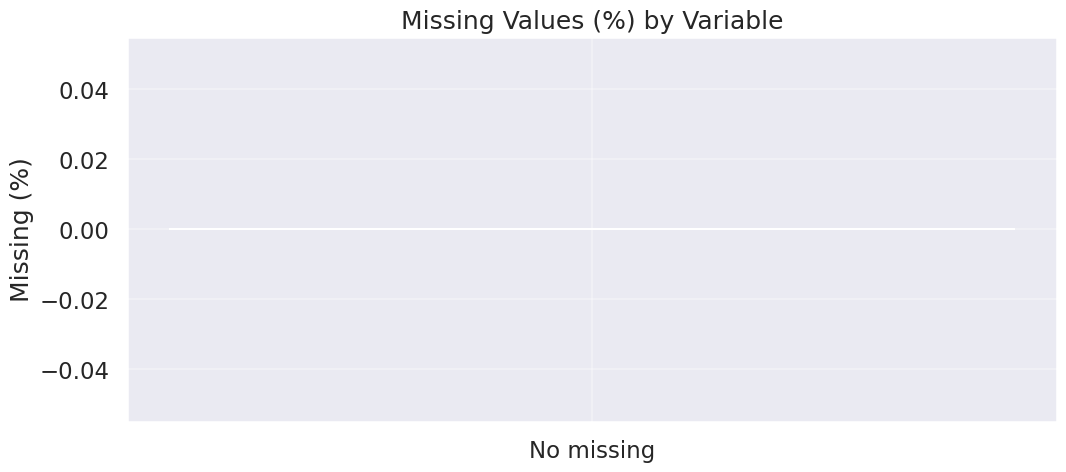

No missing values detected.
Weather cols: ['tavg', 'tmin', 'tmax', 'wspd', 'pres', 'prcp', 'temp_range_week']
Mood cols: ['NegativeMoodIndex', 'PositiveMoodIndex', 'NegativeBehaviorIndex', 'PositiveBehaviorIndex']


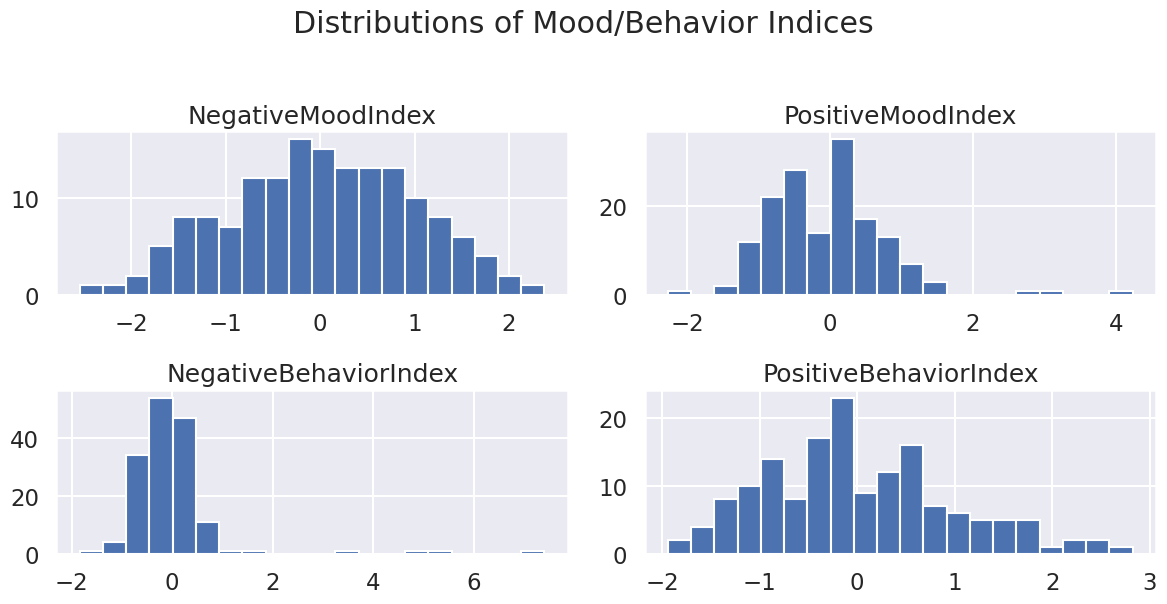

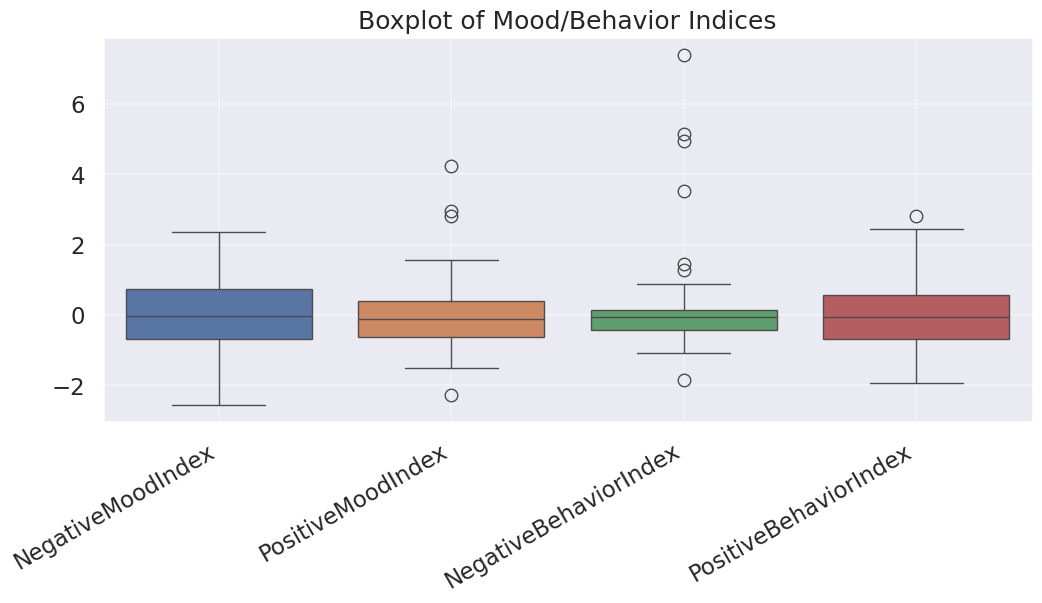

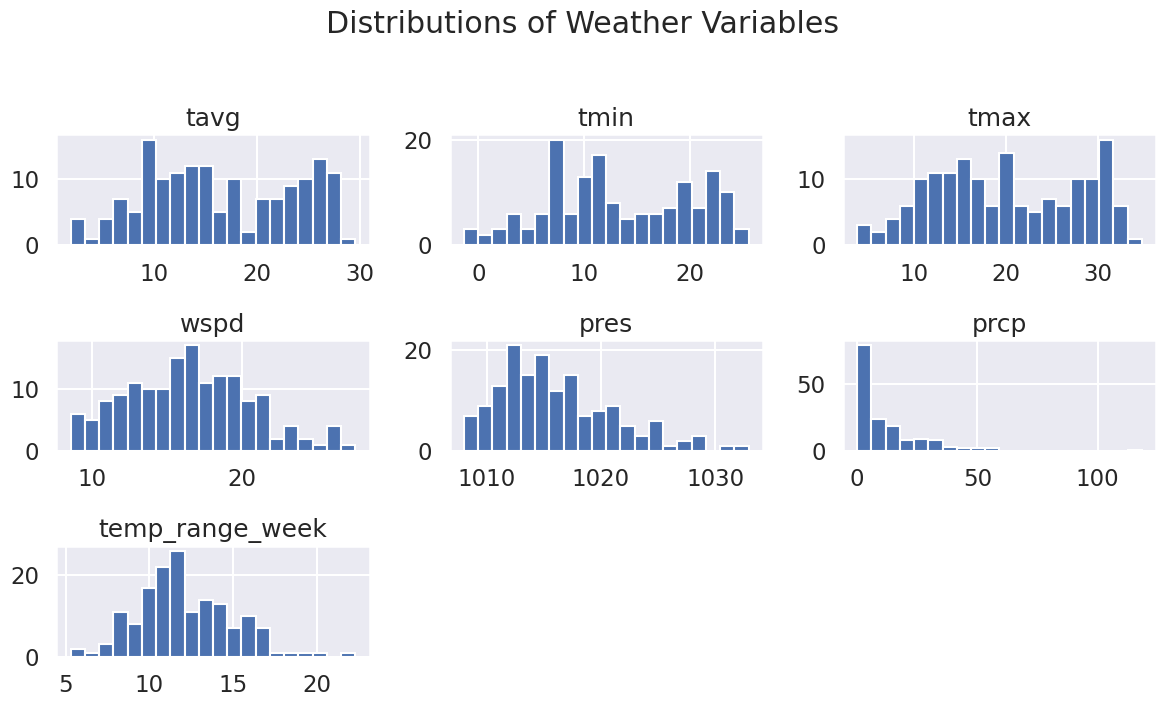

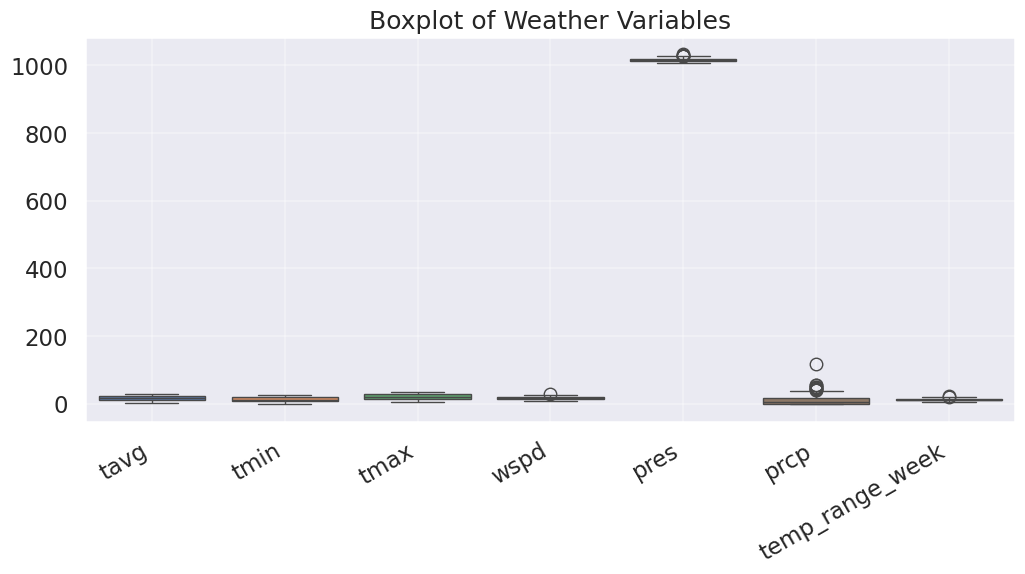

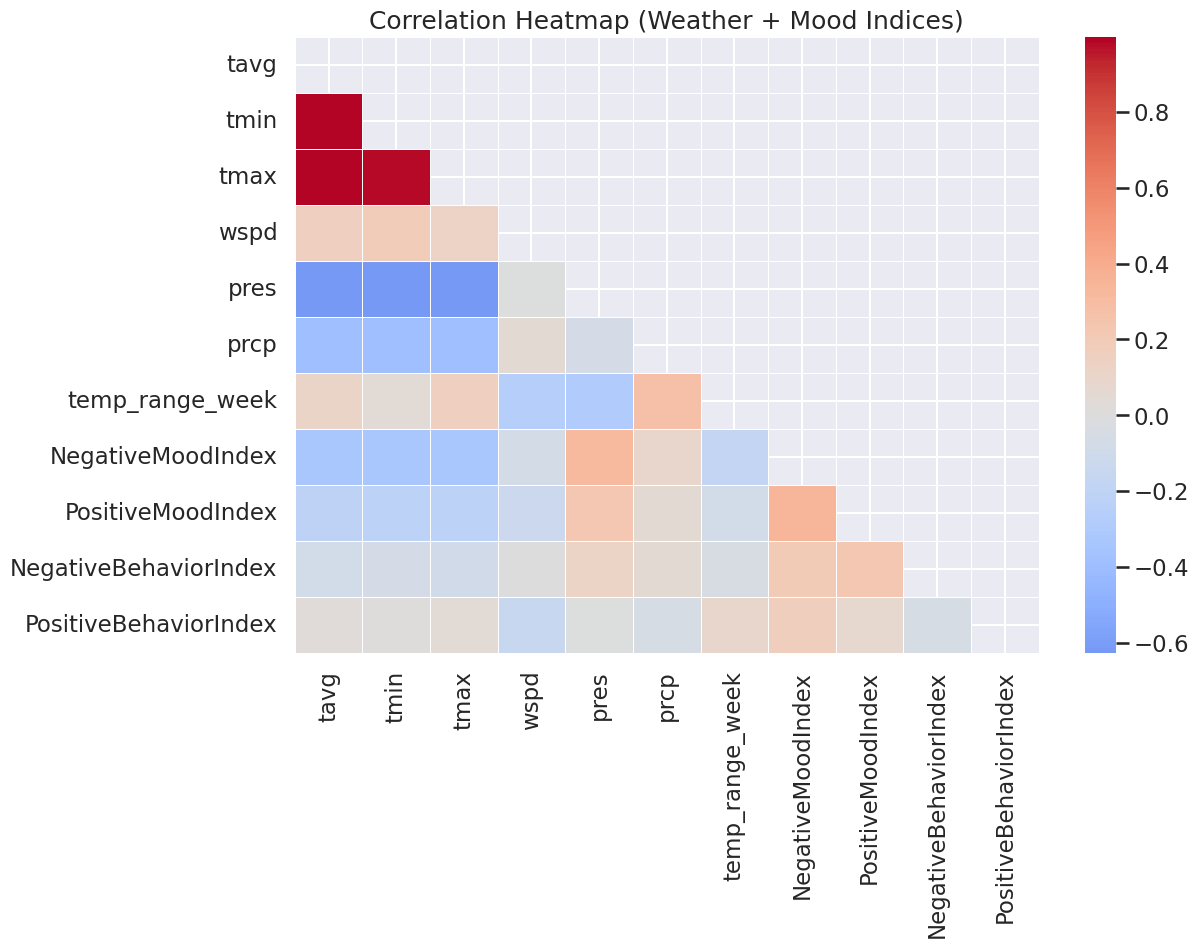

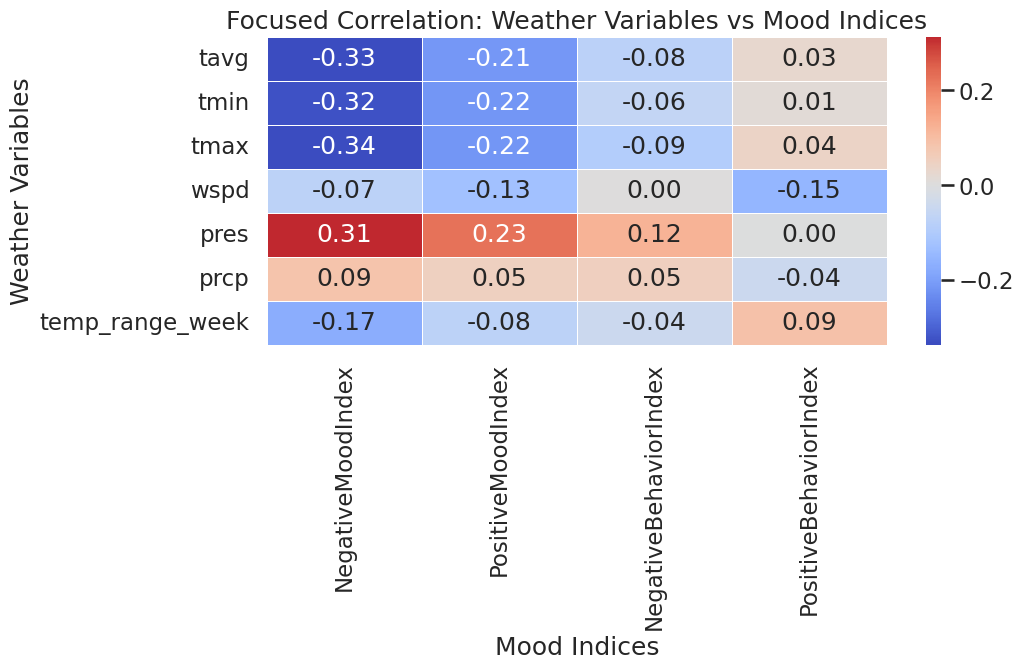

Chosen columns -> temp: tavg | positive: PositiveMoodIndex | negative: NegativeMoodIndex | precip: prcp


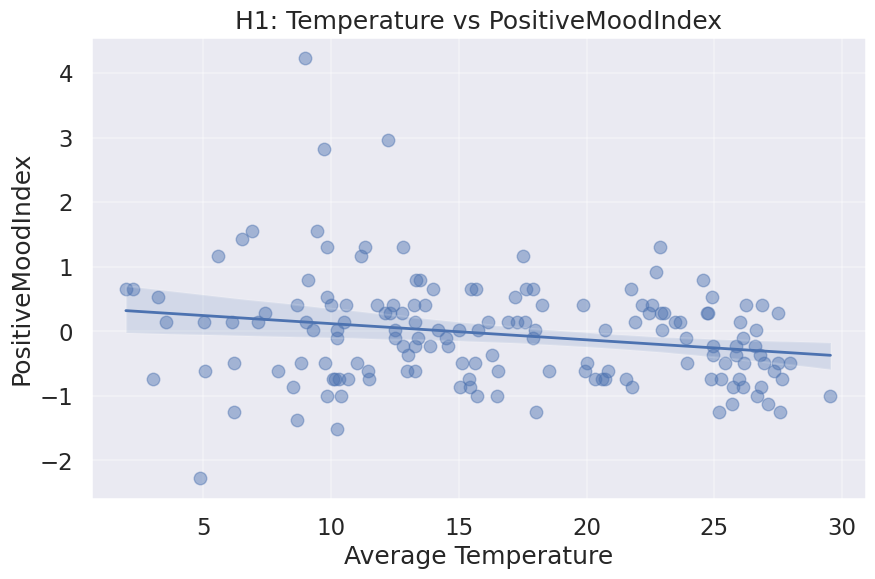

H1 Pearson r = -0.214, p = 0.00702 (n=157)


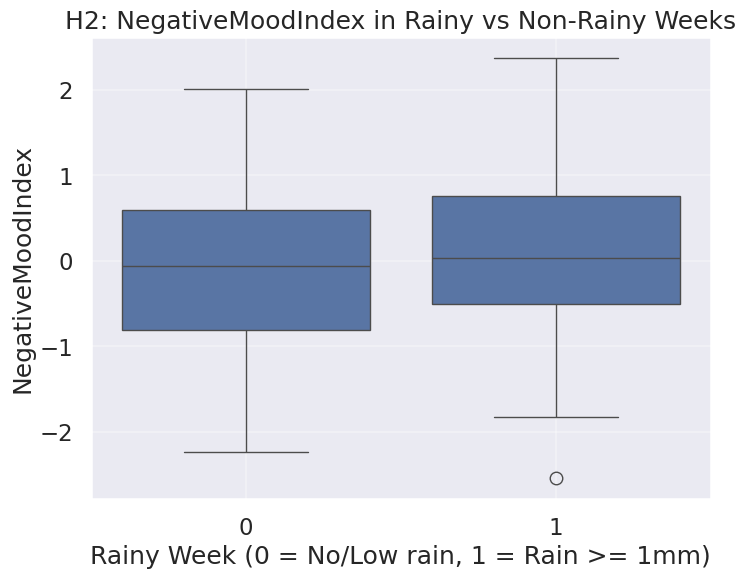

H2 Welch t-test: t = 1.141, p = 0.258 (n0=44, n1=113)


,Hypothesis,Test,r,p_value,n
0,H1,Pearson corr,-0.214372,0.007017,157
1,H2,Welch t-test,NaN,0.257585,157


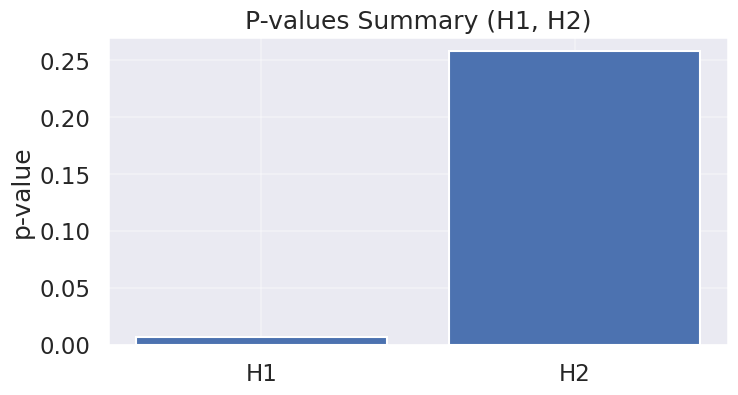

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_context("talk")

df = pd.read_csv("combined_weather_trends_istanbul_TR34_2022_2024.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

print("Shape:", df.shape)
display(df.head(3))
display(df.describe().T)

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct_nonzero = missing_pct[missing_pct > 0]

plt.figure(figsize=(12,5))
if len(missing_pct_nonzero) > 0:
    plt.bar(missing_pct_nonzero.index, missing_pct_nonzero.values)
    plt.title("Missing Values (%) by Variable")
    plt.ylabel("Missing (%)")
    plt.xticks(rotation=60, ha="right")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(12,4))
    sns.heatmap(df[missing_pct_nonzero.index].isna().T, cbar=False)
    plt.title("Missingness Pattern (only variables with missing values)")
    plt.xlabel("Week index")
    plt.ylabel("Variables")
    plt.show()
else:
    plt.bar(["No missing"], [0])
    plt.title("Missing Values (%) by Variable")
    plt.ylabel("Missing (%)")
    plt.grid(alpha=0.3)
    plt.show()
    print("No missing values detected.")

weather_cols = [c for c in df.columns if (
    c.lower() in ["tavg","tmin","tmax","prcp","wspd","pres","temp_range_week"]
    or "temp" in c.lower()
    or "precip" in c.lower()
)]

mood_cols = [c for c in df.columns if "index" in c.lower() or "mood" in c.lower() or "behavior" in c.lower()]

print("Weather cols:", weather_cols)
print("Mood cols:", mood_cols)

if len(mood_cols) > 0:
    df[mood_cols].hist(figsize=(12,6), bins=20)
    plt.suptitle("Distributions of Mood/Behavior Indices", y=1.02)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df[mood_cols])
    plt.title("Boxplot of Mood/Behavior Indices")
    plt.xticks(rotation=30, ha="right")
    plt.grid(alpha=0.3)
    plt.show()

if len(weather_cols) > 0:
    df[weather_cols].hist(figsize=(12,7), bins=20)
    plt.suptitle("Distributions of Weather Variables", y=1.02)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df[weather_cols])
    plt.title("Boxplot of Weather Variables")
    plt.xticks(rotation=30, ha="right")
    plt.grid(alpha=0.3)
    plt.show()

target_cols = [c for c in (weather_cols + mood_cols) if c in df.columns]
if len(target_cols) > 1:
    corr = df[target_cols].corr()
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5)
    plt.title("Correlation Heatmap (Weather + Mood Indices)")
    plt.show()

if len(weather_cols) > 0 and len(mood_cols) > 0:
    corr_focus = df[weather_cols + mood_cols].corr().loc[weather_cols, mood_cols]
    plt.figure(figsize=(10, max(4, 0.35*len(weather_cols))))
    sns.heatmap(corr_focus, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Focused Correlation: Weather Variables vs Mood Indices")
    plt.xlabel("Mood Indices")
    plt.ylabel("Weather Variables")
    plt.show()

temp_col = None
for c in df.columns:
    if c.lower() in ["tavg", "avg_temperature", "temperature", "temp"] or "tavg" in c.lower():
        temp_col = c

pos_col = None
neg_col = None
precip_col = None

for c in df.columns:
    if c.lower() == "positivemoodindex" or "positivemoodindex" in c.lower():
        pos_col = c
    if c.lower() == "negativemoodindex" or "negativemoodindex" in c.lower():
        neg_col = c
    if c.lower() in ["prcp", "precipitation", "precip"] or "precip" in c.lower() or "prcp" in c.lower():
        precip_col = c

print("Chosen columns -> temp:", temp_col, "| positive:", pos_col, "| negative:", neg_col, "| precip:", precip_col)

results = []

if temp_col is not None and pos_col is not None:
    tmp = df[[temp_col, pos_col]].dropna()

    plt.figure(figsize=(10,6))
    sns.regplot(data=tmp, x=temp_col, y=pos_col, scatter_kws={"alpha": 0.45}, line_kws={"linewidth": 2})
    plt.title("H1: Temperature vs PositiveMoodIndex")
    plt.xlabel("Average Temperature")
    plt.ylabel("PositiveMoodIndex")
    plt.grid(alpha=0.3)
    plt.show()

    r, p = stats.pearsonr(tmp[temp_col], tmp[pos_col])
    print(f"H1 Pearson r = {r:.3f}, p = {p:.3g} (n={len(tmp)})")
    results.append({"Hypothesis": "H1", "Test": "Pearson corr", "r": r, "p_value": p, "n": len(tmp)})

if precip_col is not None and neg_col is not None:
    tmp = df[[precip_col, neg_col]].dropna()

    tmp = tmp.copy()
    tmp["RainyWeek"] = (tmp[precip_col] >= 1.0).astype(int)

    plt.figure(figsize=(8,6))
    sns.boxplot(data=tmp, x="RainyWeek", y=neg_col)
    plt.title("H2: NegativeMoodIndex in Rainy vs Non-Rainy Weeks")
    plt.xlabel("Rainy Week (0 = No/Low rain, 1 = Rain >= 1mm)")
    plt.ylabel("NegativeMoodIndex")
    plt.grid(alpha=0.3)
    plt.show()

    group0 = tmp[tmp["RainyWeek"] == 0][neg_col].values
    group1 = tmp[tmp["RainyWeek"] == 1][neg_col].values

    if len(group0) > 1 and len(group1) > 1:
        t_stat, p_val = stats.ttest_ind(group1, group0, equal_var=False)
        print(f"H2 Welch t-test: t = {t_stat:.3f}, p = {p_val:.3g} (n0={len(group0)}, n1={len(group1)})")
        results.append({"Hypothesis": "H2", "Test": "Welch t-test", "r": np.nan, "p_value": p_val, "n": len(tmp)})

if len(results) > 0:
    res_df = pd.DataFrame(results)
    display(res_df)

    plt.figure(figsize=(8,4))
    plt.bar(res_df["Hypothesis"], res_df["p_value"])
    plt.title("P-values Summary (H1, H2)")
    plt.ylabel("p-value")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No hypothesis results computed. Check column names.")


## Additional Statistical Tests

In this section, additional statistical tests are applied to further examine
the proposed hypotheses using different perspectives.

- A **t-test** is used to compare NegativeMoodIndex between rainy and non-rainy weeks.
- A **one-way ANOVA** examines whether PositiveBehaviorIndex differs across
  temperature groups (cold, mild, warm).
- A **chi-square test** evaluates the association between high negative mood
  and rainy conditions.
- Finally, a focused correlation heatmap summarizes relationships between key
  weather variables and mood/behavior indices.


The additional statistical tests suggest that the relationship between weather conditions and online mood or behavior indices is generally weak. While some statistically significant results may appear for temperature–mood correlations, the effect sizes are small and inconsistent with the hypothesized direction. Differences in mood or behavior across rainy versus non-rainy weeks and temperature groups are not statistically significant. Overall, the findings indicate that any weather–mood relationship in this dataset is subtle and not robustly supported by statistical evidence

T-test: NegativeMoodIndex (Rainy vs Dry)
t-statistic: 1.1407396136053003
p-value    : 0.25758458014012703

ANOVA: PositiveBehaviorIndex ~ Temperature Group
F-statistic: 0.5385985865895048
p-value    : 0.5846606803504784

Chi-square test: HighNegativeMood vs Rain
Chi2 statistic: 0.01635850963382604
p-value       : 0.8982278028035575
Degrees of freedom: 1
Contingency table:
 is_rainy           0   1
HighNegativeMood        
0                 23  56
1                 21  57


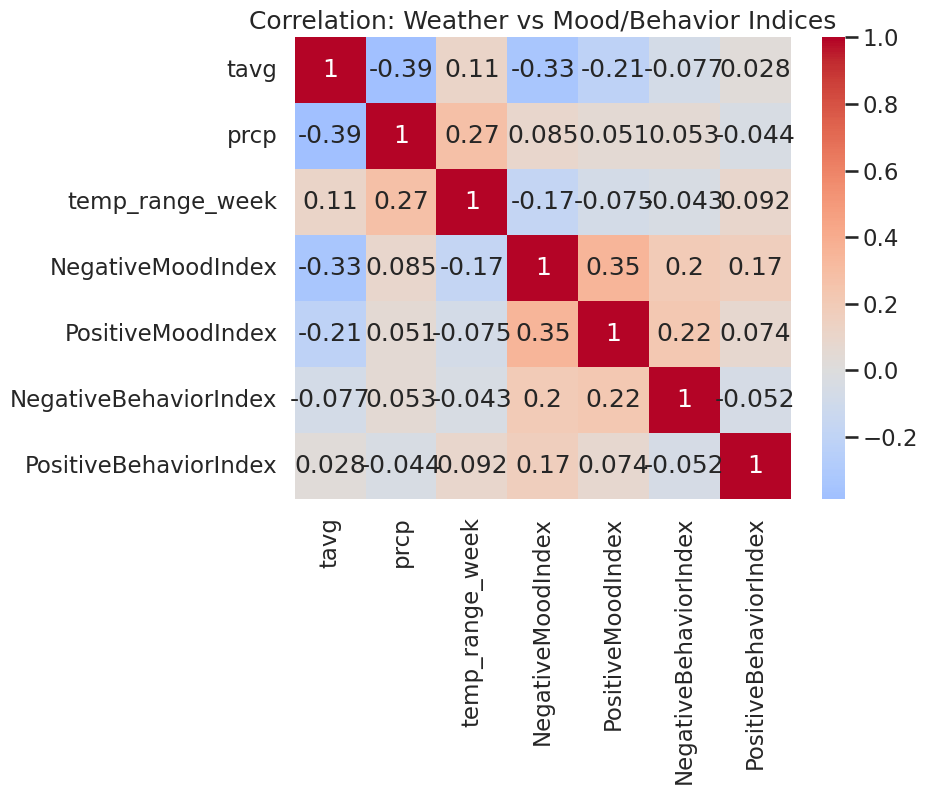

In [9]:
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(
    "combined_weather_trends_istanbul_TR34_2022_2024.csv",
    index_col=0
)
df.index = pd.to_datetime(df.index)

df["is_rainy"] = (df["prcp"] >= 1.0).astype(int)

df["temp_group"] = pd.cut(
    df["tavg"],
    bins=[-50, 10, 20, 50],
    labels=["cold", "mild", "warm"]
)

median_neg_mood = df["NegativeMoodIndex"].median()
df["HighNegativeMood"] = (df["NegativeMoodIndex"] > median_neg_mood).astype(int)

rainy = df[df["is_rainy"] == 1]["NegativeMoodIndex"].dropna()
dry   = df[df["is_rainy"] == 0]["NegativeMoodIndex"].dropna()

t_stat, p_val = stats.ttest_ind(rainy, dry, equal_var=False)

print("T-test: NegativeMoodIndex (Rainy vs Dry)")
print("t-statistic:", t_stat)
print("p-value    :", p_val)

cold = df[df["temp_group"] == "cold"]["PositiveBehaviorIndex"].dropna()
mild = df[df["temp_group"] == "mild"]["PositiveBehaviorIndex"].dropna()
warm = df[df["temp_group"] == "warm"]["PositiveBehaviorIndex"].dropna()

f_stat, p_val = f_oneway(cold, mild, warm)

print("\nANOVA: PositiveBehaviorIndex ~ Temperature Group")
print("F-statistic:", f_stat)
print("p-value    :", p_val)

ct = pd.crosstab(df["HighNegativeMood"], df["is_rainy"])

chi2, p_val, dof, expected = chi2_contingency(ct)

print("\nChi-square test: HighNegativeMood vs Rain")
print("Chi2 statistic:", chi2)
print("p-value       :", p_val)
print("Degrees of freedom:", dof)
print("Contingency table:\n", ct)

cols_of_interest = [
    "tavg", "prcp", "temp_range_week",
    "NegativeMoodIndex", "PositiveMoodIndex",
    "NegativeBehaviorIndex", "PositiveBehaviorIndex"
]

corr_subset = df[cols_of_interest].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_subset, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation: Weather vs Mood/Behavior Indices")
plt.show()


This study examined the relationship between weather conditions and collective mood and behavior in Istanbul using meteorological data and Google Trends–based mood and behavior indices. The analysis combined weekly aggregated weather variables with standardized online search indicators to evaluate whether environmental factors are associated with changes in public emotional states and behaviors.

Overall, the results indicate that the relationship between weather conditions and online mood or behavior indices is generally weak. Correlation analysis reveals only small effect sizes between temperature, precipitation, and mood-related measures, with no strong or consistent patterns across indices. While some temperature–mood correlations appear statistically significant, their magnitudes are limited and, in certain cases, inconsistent with the hypothesized direction.

Additional statistical tests, including t-tests, one-way ANOVA, and chi-square analysis, do not provide robust evidence supporting meaningful differences in mood or behavior between rainy and non-rainy weeks or across temperature groups. These findings suggest that weather variables alone are not strong predictors of collective mood or behavior as reflected in online search activity.

In summary, the analysis suggests that any weather–mood relationship observable in this dataset is subtle and not robustly supported by statistical evidence. Collective mood and behavior are likely influenced by a broader set of social, economic, and psychological factors beyond short-term weather conditions, which are not captured within the scope of this study

# Machine Learning Methods

In this section, we apply simple machine learning methods to the dataset.
The goal is not high-accuracy prediction, but to test whether weather variables
carry predictive signal for mood indicators and to explore patterns in the data.


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

df_ml = pd.read_csv("combined_weather_trends_istanbul_TR34_2022_2024.csv", index_col=0)
df_ml.index = pd.to_datetime(df_ml.index)
df_ml = df_ml.sort_index()

features = ["tavg", "prcp", "wspd", "pres", "temp_range_week"]
target = "PositiveMoodIndex"   # istersen sonra değiştiririz

df_ml = df_ml.dropna(subset=features + [target]).copy()

X = df_ml[features]
y = df_ml[target]

tscv = TimeSeriesSplit(n_splits=5)

def eval_cv(model, X, y, cv):
    rmses = []
    maes = []
    r2s = []
    for train_idx, test_idx in cv.split(X):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)

        rmses.append(rmse)
        maes.append(mae)
        r2s.append(r2)

    return {
        "RMSE_mean": float(np.mean(rmses)),
        "RMSE_std": float(np.std(rmses)),
        "MAE_mean": float(np.mean(maes)),
        "R2_mean": float(np.mean(r2s)),
    }

# 1) KNN (Scaling şart) :contentReference[oaicite:2]{index=2}
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

knn_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "knn__weights": ["uniform", "distance"]
}

knn_search = GridSearchCV(
    knn_pipe,
    knn_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)
knn_search.fit(X, y)

# 2) Decision Tree :contentReference[oaicite:3]{index=3}
tree = DecisionTreeRegressor(random_state=42)
tree_grid = {
    "max_depth": [2, 3, 4, 5, 6, 8, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10]
}
tree_search = GridSearchCV(
    tree,
    tree_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)
tree_search.fit(X, y)

# 3) Random Forest :contentReference[oaicite:4]{index=4}
rf = RandomForestRegressor(random_state=42)
rf_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 3, 5, 8],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}
rf_search = GridSearchCV(
    rf,
    rf_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
rf_search.fit(X, y)

models = [
    ("KNN(best)", knn_search.best_estimator_),
    ("Tree(best)", tree_search.best_estimator_),
    ("RF(best)", rf_search.best_estimator_),
]

results = []
for name, m in models:
    met = eval_cv(m, X, y, tscv)
    met["Model"] = name
    results.append(met)

res_df = pd.DataFrame(results)[["Model","RMSE_mean","RMSE_std","MAE_mean","R2_mean"]]
display(res_df)

print("Best KNN params:", knn_search.best_params_)
print("Best Tree params:", tree_search.best_params_)
print("Best RF params:", rf_search.best_params_)


,Model,RMSE_mean,RMSE_std,MAE_mean,R2_mean
0,KNN(best),0.943574,0.159693,0.740653,-1.388696
1,Tree(best),0.936883,0.138061,0.747340,-1.375351
2,RF(best),0.953210,0.152592,0.751289,-1.522972


Best KNN params: {'knn__n_neighbors': 21, 'knn__weights': 'uniform'}
Best Tree params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best RF params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


from matplotlib import pyplot as plt
res_df['RMSE_mean'].plot(kind='hist', bins=20, title='RMSE_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['RMSE_std'].plot(kind='hist', bins=20, title='RMSE_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['MAE_mean'].plot(kind='hist', bins=20, title='MAE_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['R2_mean'].plot(kind='hist', bins=20, title='R2_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
res_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df.plot(kind='scatter', x='RMSE_mean', y='RMSE_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df.plot(kind='scatter', x='RMSE_std', y='MAE_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df.plot(kind='scatter', x='MAE_mean', y='R2_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE_mean']
  ys = series['RMSE_mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = res_df.sort_values('MAE_mean', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE_mean')
_ = plt.ylabel('RMSE_mean')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE_mean']
  ys = series['RMSE_std']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = res_df.sort_values('MAE_mean', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE_mean')
_ = plt.ylabel('RMSE_std')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE_mean']
  ys = series['R2_mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = res_df.sort_values('MAE_mean', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE_mean')
_ = plt.ylabel('R2_mean')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE_mean']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE_mean'}, axis=1)
              .sort_values('MAE_mean', ascending=True))
  xs = counted['MAE_mean']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = res_df.sort_values('MAE_mean', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE_mean')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
res_df['RMSE_mean'].plot(kind='line', figsize=(8, 4), title='RMSE_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_df['RMSE_std'].plot(kind='line', figsize=(8, 4), title='RMSE_std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_df['MAE_mean'].plot(kind='line', figsize=(8, 4), title='MAE_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_df['R2_mean'].plot(kind='line', figsize=(8, 4), title='R2_mean')
plt.gca().spines[['top', 'right']].set_visible(False)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(res_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_df, x='RMSE_mean', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(res_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_df, x='RMSE_std', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(res_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_df, x='MAE_mean', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(res_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_df, x='R2_mean', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Machine Learning Results and Interpretation

Simple machine learning models were applied to evaluate whether weather variables could predict mood-related indices beyond linear statistical relationships. K-Nearest Neighbors, Decision Tree, and Random Forest regressors were trained using time-series cross-validation to avoid information leakage.

Across all models, predictive performance remained weak. Root Mean Squared Error (RMSE) values were relatively high compared to the scale of the target variable, and R² scores were negative for all models. This indicates that the models performed worse than a naive baseline that predicts the mean value of the target.

These findings suggest that weather variables such as temperature, precipitation, wind speed, and atmospheric pressure do not contain sufficient predictive signal to accurately estimate online mood indicators on their own. The results are consistent with earlier statistical analyses, which also indicated weak and inconsistent relationships between weather conditions and mood or behavior indices.

Overall, the machine learning analysis reinforces the conclusion that collective mood and behavior are influenced by a broader set of factors beyond short-term weather conditions, and that weather-based prediction of online mood is limited in this dataset.
